# Tesla (TSLA) Stock Price Prediction — LSTM, BiLSTM & GRU 📈

**Overview (in simple English):**

This notebook teaches you how to predict Tesla's (TSLA) **next-day closing price** using three recurrent neural network types: **LSTM**, **Bidirectional LSTM (BiLSTM)**, and **GRU**. The notebook is written step-by-step with detailed Markdown explanations so even a beginner or a high-school student can follow. You will download historical data from Yahoo Finance, explore the data, prepare it for time-series modeling, build and train models, evaluate them, and visualize predictions.

**Data range:** `2015-01-01` to today (2025-10-14). Adjust dates as needed.

---

**What you will learn:**

- How to download stock data using `yfinance`.
- How to prepare time-series sequences (sliding windows).
- How to build three simple recurrent architectures (LSTM, BiLSTM, GRU).
- How to train models with early stopping and checkpoints.
- How to evaluate models using MAE, RMSE, and MAPE.
- How to visualize actual vs predicted prices.

---

**How to run:** Execute cells sequentially. If you lack internet on your machine, replace the data-download cell with a local CSV containing Tesla historical prices.


In [1]:
## 1) Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# reproducibility
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

print('Libraries loaded')


Libraries loaded


## 2) Download TSLA historical data

We'll download daily Tesla stock prices (ticker `TSLA`) using `yfinance`. We'll use the **Close** price as the main target for this example. The time window is from **2015-01-01** to today.

In [6]:
# Download
start = '2015-01-01'
end = '2025-10-14'

df = yf.download('TSLA', start=start, end=end)
df.head()


/tmp/ipython-input-2011661014.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TSLA', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


## 3) Quick EDA

Let's inspect the data for missing values and visualize the closing price trend. Observing the plot helps you understand the volatility and trends the models must learn.

Shape: (2711, 5)

Missing values:
 Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64


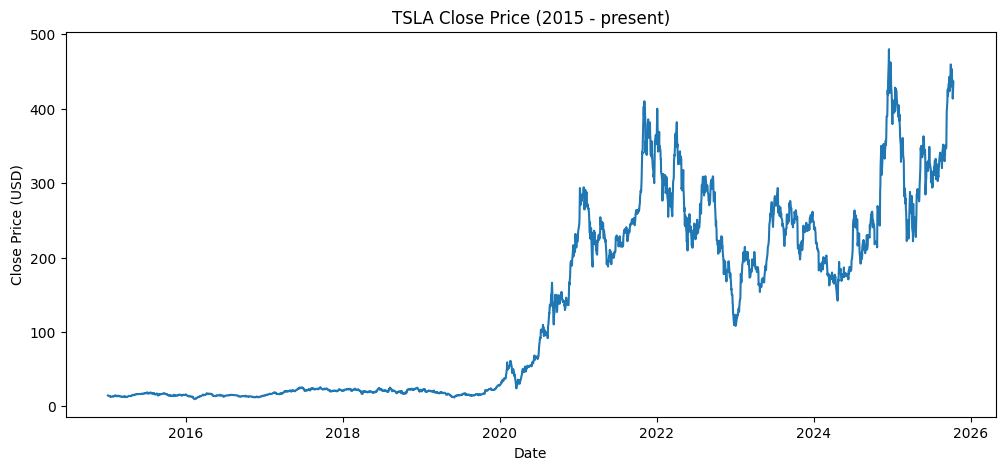

In [7]:
# Basic info
print('Shape:', df.shape)
print('\nMissing values:\n', df.isna().sum())

# Plot Close price
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'])
plt.title('TSLA Close Price (2015 - present)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.show()


In [4]:
import os
SEQ_LEN = 60         # how many past days we feed to predict next day
FUTURE_DAYS = 30     # forecast horizon for final demo
TEST_RATIO = 0.15
VAL_RATIO = 0.10
BATCH = 32
EPOCHS = 30
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)


In [8]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].copy()
data = data.ffill().dropna()   # forward fill then drop remaining NaNs if any
print("After ffill shape:", data.shape)

After ffill shape: (2711, 5)


In [16]:
import joblib
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)   # shape (n_days, 5)
# Save scaler to reuse in deployment
joblib.dump(scaler, os.path.join(MODEL_DIR, "tesla_multiple_input_scaler.gz"))
print("Scaler saved.")

Scaler saved.


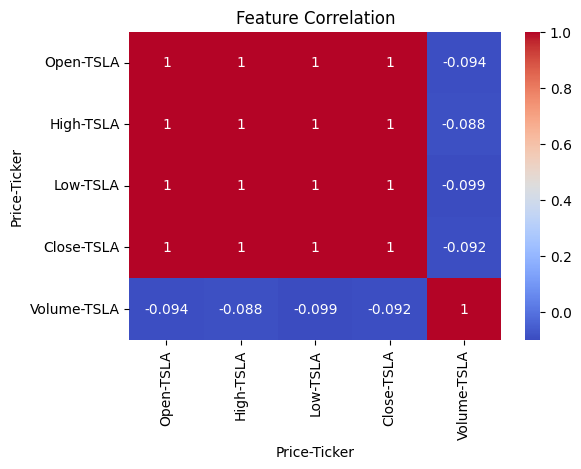

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(df[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()  # shape (n_samples, 1)

In [11]:
# Cell 8 — create sequences (multivariate)
def create_multivariate_sequences(scaled_array, seq_len):
    X, y = [], []
    for i in range(seq_len, len(scaled_array)):
        X.append(scaled_array[i-seq_len:i, :])   # seq_len x n_features
        # target: next-day close (column index for 'Close' is 3 in our features)
        y.append(scaled_array[i, features.index('Close')])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_all, y_all = create_multivariate_sequences(scaled_data, SEQ_LEN)
print("X_all shape:", X_all.shape, "y_all shape:", y_all.shape)


X_all shape: (2651, 60, 5) y_all shape: (2651,)


## 4) Preprocessing

We'll use the **Close** column only (univariate forecasting). Steps:

1. Keep `Close` column and scale it with `MinMaxScaler` to range [0,1].
2. Create sliding windows (lookback/sequence length = 60 days) so each sample uses 60 past days to predict the next day.
3. Split into time-ordered train/validation/test sets (80% train, 10% val, 10% test).


### 4.1) Time-based train/validation/test split

We keep chronological order: first 80% for training, next 10% validation, final 10% test.


In [12]:
# Cell 9 — time-aware split
n = len(X_all)
test_size = int(n * TEST_RATIO)
val_size = int(n * VAL_RATIO)

train_end = n - test_size - val_size
val_end = n - test_size

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (1989, 60, 5) (1989,)
Val:   (265, 60, 5) (265,)
Test:  (397, 60, 5) (397,)


## 5) Model building: LSTM, BiLSTM, GRU

We'll create simple, comparable architectures for the three model types. Keep them compact so they train reasonably fast on a laptop/GPU.

In [13]:
# Cell 10 — Helper build functions (simple & clear models)
def build_lstm(input_shape, units=64, dropout=0.2):
    m = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units//2),
        Dropout(dropout),
        Dense(1)
    ])
    return m

def build_bilstm(input_shape, units=64, dropout=0.2):
    m = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape),
        Dropout(dropout),
        Bidirectional(LSTM(units//2)),
        Dropout(dropout),
        Dense(1)
    ])
    return m

def build_gru(input_shape, units=64, dropout=0.2):
    m = Sequential([
        GRU(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        GRU(units//2),
        Dropout(dropout),
        Dense(1)
    ])
    return m


## 6) Train models

We will train each model with early stopping and save the best weights using ModelCheckpoint. Training on CPUs may take time; reduce epochs if needed.

In [14]:
# Cell 11 — training helper
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
def compile_and_train(model, name, X_train, y_train, X_val, y_val, epochs=EPOCHS):
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint(os.path.join(MODEL_DIR, f"{name}.h5"), monitor='val_loss', save_best_only=True, verbose=1)
    ]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=BATCH, callbacks=callbacks, verbose=2)
    return history


In [15]:
# Cell 12 — Build & train LSTM (simple)
input_shape = (X_train.shape[1], X_train.shape[2])
lstm = build_lstm(input_shape, units=128, dropout=0.2)
lstm_hist = compile_and_train(lstm, "lstm_multifeature", X_train, y_train, X_val, y_val)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00207, saving model to saved_models/lstm_multifeature.h5


63/63 - 12s - 194ms/step - loss: 0.0229 - mae: 0.0810 - val_loss: 0.0021 - val_mae: 0.0360 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss did not improve from 0.00207
63/63 - 10s - 158ms/step - loss: 0.0024 - mae: 0.0291 - val_loss: 0.0021 - val_mae: 0.0361 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.00207 to 0.00185, saving model to saved_models/lstm_multifeature.h5


63/63 - 8s - 123ms/step - loss: 0.0022 - mae: 0.0258 - val_loss: 0.0018 - val_mae: 0.0343 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss did not improve from 0.00185
63/63 - 7s - 103ms/step - loss: 0.0020 - mae: 0.0245 - val_loss: 0.0020 - val_mae: 0.0351 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss did not improve from 0.00185
63/63 - 8s - 123ms/step - loss: 0.0018 - mae: 0.0227 - val_loss: 0.0019 - val_mae: 0.0341 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_loss improved from 0.00185 to 0.00155, saving model to saved_models/lstm_multifeature.h5


63/63 - 7s - 104ms/step - loss: 0.0017 - mae: 0.0220 - val_loss: 0.0015 - val_mae: 0.0316 - learning_rate: 1.0000e-04
Epoch 7/30

Epoch 7: val_loss improved from 0.00155 to 0.00147, saving model to saved_models/lstm_multifeature.h5


63/63 - 10s - 160ms/step - loss: 0.0017 - mae: 0.0217 - val_loss: 0.0015 - val_mae: 0.0308 - learning_rate: 1.0000e-04
Epoch 8/30

Epoch 8: val_loss improved from 0.00147 to 0.00140, saving model to saved_models/lstm_multifeature.h5


63/63 - 8s - 123ms/step - loss: 0.0017 - mae: 0.0215 - val_loss: 0.0014 - val_mae: 0.0302 - learning_rate: 1.0000e-04
Epoch 9/30

Epoch 9: val_loss did not improve from 0.00140
63/63 - 7s - 104ms/step - loss: 0.0016 - mae: 0.0206 - val_loss: 0.0014 - val_mae: 0.0302 - learning_rate: 1.0000e-04
Epoch 10/30

Epoch 10: val_loss did not improve from 0.00140
63/63 - 8s - 131ms/step - loss: 0.0015 - mae: 0.0204 - val_loss: 0.0016 - val_mae: 0.0317 - learning_rate: 1.0000e-04
Epoch 11/30

Epoch 11: val_loss improved from 0.00140 to 0.00124, saving model to saved_models/lstm_multifeature.h5


63/63 - 10s - 153ms/step - loss: 0.0014 - mae: 0.0197 - val_loss: 0.0012 - val_mae: 0.0286 - learning_rate: 1.0000e-04
Epoch 12/30

Epoch 12: val_loss did not improve from 0.00124
63/63 - 6s - 102ms/step - loss: 0.0013 - mae: 0.0184 - val_loss: 0.0014 - val_mae: 0.0298 - learning_rate: 1.0000e-04
Epoch 13/30

Epoch 13: val_loss did not improve from 0.00124
63/63 - 9s - 138ms/step - loss: 0.0013 - mae: 0.0190 - val_loss: 0.0014 - val_mae: 0.0297 - learning_rate: 1.0000e-04
Epoch 14/30

Epoch 14: val_loss improved from 0.00124 to 0.00111, saving model to saved_models/lstm_multifeature.h5


63/63 - 8s - 128ms/step - loss: 0.0013 - mae: 0.0192 - val_loss: 0.0011 - val_mae: 0.0272 - learning_rate: 1.0000e-04
Epoch 15/30

Epoch 15: val_loss did not improve from 0.00111
63/63 - 11s - 174ms/step - loss: 0.0011 - mae: 0.0176 - val_loss: 0.0013 - val_mae: 0.0285 - learning_rate: 1.0000e-04
Epoch 16/30

Epoch 16: val_loss did not improve from 0.00111
63/63 - 8s - 125ms/step - loss: 0.0012 - mae: 0.0183 - val_loss: 0.0017 - val_mae: 0.0330 - learning_rate: 1.0000e-04
Epoch 17/30

Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 17: val_loss did not improve from 0.00111
63/63 - 12s - 190ms/step - loss: 0.0012 - mae: 0.0181 - val_loss: 0.0013 - val_mae: 0.0284 - learning_rate: 1.0000e-04
Epoch 18/30

Epoch 18: val_loss did not improve from 0.00111
63/63 - 16s - 247ms/step - loss: 0.0013 - mae: 0.0187 - val_loss: 0.0013 - val_mae: 0.0289 - learning_rate: 5.0000e-05
Epoch 19/30

Epoch 19: val_loss did not improve from 0.00111
63/63 - 9s - 140ms/step 

In [17]:
# Cell 13 — Build & train BiLSTM
bilstm = build_bilstm(input_shape, units=128, dropout=0.2)
bilstm_hist = compile_and_train(bilstm, "bilstm_multifeature", X_train, y_train, X_val, y_val)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00367, saving model to saved_models/bilstm_multifeature.h5


63/63 - 29s - 457ms/step - loss: 0.0180 - mae: 0.0699 - val_loss: 0.0037 - val_mae: 0.0514 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.00367 to 0.00254, saving model to saved_models/bilstm_multifeature.h5


63/63 - 17s - 267ms/step - loss: 0.0031 - mae: 0.0338 - val_loss: 0.0025 - val_mae: 0.0418 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.00254 to 0.00173, saving model to saved_models/bilstm_multifeature.h5


63/63 - 18s - 279ms/step - loss: 0.0024 - mae: 0.0281 - val_loss: 0.0017 - val_mae: 0.0330 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.00173 to 0.00134, saving model to saved_models/bilstm_multifeature.h5


63/63 - 17s - 266ms/step - loss: 0.0020 - mae: 0.0249 - val_loss: 0.0013 - val_mae: 0.0283 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss improved from 0.00134 to 0.00130, saving model to saved_models/bilstm_multifeature.h5


63/63 - 16s - 257ms/step - loss: 0.0018 - mae: 0.0223 - val_loss: 0.0013 - val_mae: 0.0282 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_loss improved from 0.00130 to 0.00107, saving model to saved_models/bilstm_multifeature.h5


63/63 - 22s - 344ms/step - loss: 0.0016 - mae: 0.0211 - val_loss: 0.0011 - val_mae: 0.0256 - learning_rate: 1.0000e-04
Epoch 7/30

Epoch 7: val_loss did not improve from 0.00107
63/63 - 19s - 304ms/step - loss: 0.0015 - mae: 0.0205 - val_loss: 0.0012 - val_mae: 0.0274 - learning_rate: 1.0000e-04
Epoch 8/30

Epoch 8: val_loss improved from 0.00107 to 0.00097, saving model to saved_models/bilstm_multifeature.h5


63/63 - 18s - 283ms/step - loss: 0.0014 - mae: 0.0202 - val_loss: 9.6631e-04 - val_mae: 0.0244 - learning_rate: 1.0000e-04
Epoch 9/30

Epoch 9: val_loss improved from 0.00097 to 0.00093, saving model to saved_models/bilstm_multifeature.h5


63/63 - 17s - 263ms/step - loss: 0.0013 - mae: 0.0195 - val_loss: 9.3390e-04 - val_mae: 0.0241 - learning_rate: 1.0000e-04
Epoch 10/30

Epoch 10: val_loss improved from 0.00093 to 0.00092, saving model to saved_models/bilstm_multifeature.h5


63/63 - 16s - 260ms/step - loss: 0.0013 - mae: 0.0191 - val_loss: 9.1709e-04 - val_mae: 0.0240 - learning_rate: 1.0000e-04
Epoch 11/30

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 11: val_loss improved from 0.00092 to 0.00088, saving model to saved_models/bilstm_multifeature.h5


63/63 - 18s - 291ms/step - loss: 0.0011 - mae: 0.0179 - val_loss: 8.7712e-04 - val_mae: 0.0235 - learning_rate: 1.0000e-04
Epoch 12/30

Epoch 12: val_loss did not improve from 0.00088
63/63 - 17s - 271ms/step - loss: 0.0011 - mae: 0.0181 - val_loss: 9.0433e-04 - val_mae: 0.0239 - learning_rate: 5.0000e-05
Epoch 13/30

Epoch 13: val_loss improved from 0.00088 to 0.00079, saving model to saved_models/bilstm_multifeature.h5


63/63 - 17s - 269ms/step - loss: 0.0011 - mae: 0.0175 - val_loss: 7.8701e-04 - val_mae: 0.0222 - learning_rate: 5.0000e-05
Epoch 14/30

Epoch 14: val_loss did not improve from 0.00079
63/63 - 21s - 330ms/step - loss: 0.0010 - mae: 0.0170 - val_loss: 8.6200e-04 - val_mae: 0.0234 - learning_rate: 5.0000e-05
Epoch 15/30

Epoch 15: val_loss did not improve from 0.00079
63/63 - 18s - 279ms/step - loss: 0.0011 - mae: 0.0180 - val_loss: 0.0014 - val_mae: 0.0302 - learning_rate: 5.0000e-05
Epoch 16/30

Epoch 16: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 16: val_loss did not improve from 0.00079
63/63 - 18s - 292ms/step - loss: 9.7261e-04 - mae: 0.0170 - val_loss: 0.0010 - val_mae: 0.0259 - learning_rate: 5.0000e-05
Epoch 17/30

Epoch 17: val_loss did not improve from 0.00079
63/63 - 16s - 262ms/step - loss: 0.0010 - mae: 0.0173 - val_loss: 0.0011 - val_mae: 0.0266 - learning_rate: 2.5000e-05
Epoch 18/30

Epoch 18: val_loss improved from 0.00079 to 0.00078, savin

63/63 - 17s - 263ms/step - loss: 0.0010 - mae: 0.0171 - val_loss: 7.8155e-04 - val_mae: 0.0223 - learning_rate: 2.5000e-05
Epoch 19/30

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 19: val_loss did not improve from 0.00078
63/63 - 17s - 274ms/step - loss: 9.7939e-04 - mae: 0.0168 - val_loss: 0.0010 - val_mae: 0.0260 - learning_rate: 2.5000e-05
Epoch 20/30

Epoch 20: val_loss did not improve from 0.00078
63/63 - 16s - 258ms/step - loss: 9.8001e-04 - mae: 0.0168 - val_loss: 8.9820e-04 - val_mae: 0.0241 - learning_rate: 1.2500e-05
Epoch 21/30

Epoch 21: val_loss did not improve from 0.00078
63/63 - 16s - 254ms/step - loss: 9.1938e-04 - mae: 0.0168 - val_loss: 0.0010 - val_mae: 0.0255 - learning_rate: 1.2500e-05
Epoch 22/30

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 22: val_loss did not improve from 0.00078
63/63 - 16s - 252ms/step - loss: 9.8496e-04 - mae: 0.0167 - val_loss: 8.4346e-04 - val_mae: 0.0233 - lear

63/63 - 18s - 286ms/step - loss: 8.5515e-04 - mae: 0.0161 - val_loss: 7.5667e-04 - val_mae: 0.0219 - learning_rate: 6.2500e-06
Epoch 24/30

Epoch 24: val_loss did not improve from 0.00076
63/63 - 16s - 259ms/step - loss: 9.2101e-04 - mae: 0.0164 - val_loss: 7.7173e-04 - val_mae: 0.0222 - learning_rate: 6.2500e-06
Epoch 25/30

Epoch 25: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 25: val_loss improved from 0.00076 to 0.00075, saving model to saved_models/bilstm_multifeature.h5


63/63 - 16s - 257ms/step - loss: 0.0010 - mae: 0.0171 - val_loss: 7.4517e-04 - val_mae: 0.0217 - learning_rate: 6.2500e-06
Epoch 26/30

Epoch 26: val_loss did not improve from 0.00075
63/63 - 17s - 266ms/step - loss: 9.0120e-04 - mae: 0.0165 - val_loss: 7.5209e-04 - val_mae: 0.0219 - learning_rate: 3.1250e-06
Epoch 27/30

Epoch 27: val_loss did not improve from 0.00075
63/63 - 20s - 314ms/step - loss: 9.7969e-04 - mae: 0.0171 - val_loss: 8.4160e-04 - val_mae: 0.0233 - learning_rate: 3.1250e-06
Epoch 28/30

Epoch 28: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 28: val_loss did not improve from 0.00075
63/63 - 16s - 256ms/step - loss: 9.2952e-04 - mae: 0.0167 - val_loss: 7.8316e-04 - val_mae: 0.0224 - learning_rate: 3.1250e-06
Epoch 29/30

Epoch 29: val_loss did not improve from 0.00075
63/63 - 17s - 276ms/step - loss: 9.4259e-04 - mae: 0.0169 - val_loss: 7.6525e-04 - val_mae: 0.0221 - learning_rate: 1.5625e-06
Epoch 30/30

Epoch 30: val_loss did not improve 

In [18]:
# Cell 14 — Build & train GRU
gru = build_gru(input_shape, units=128, dropout=0.2)
gru_hist = compile_and_train(gru, "gru_multifeature", X_train, y_train, X_val, y_val)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00083, saving model to saved_models/gru_multifeature.h5


63/63 - 12s - 192ms/step - loss: 0.0096 - mae: 0.0588 - val_loss: 8.2938e-04 - val_mae: 0.0232 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss did not improve from 0.00083
63/63 - 8s - 122ms/step - loss: 0.0018 - mae: 0.0232 - val_loss: 9.2482e-04 - val_mae: 0.0242 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.00083 to 0.00065, saving model to saved_models/gru_multifeature.h5


63/63 - 9s - 144ms/step - loss: 0.0014 - mae: 0.0211 - val_loss: 6.4797e-04 - val_mae: 0.0200 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss did not improve from 0.00065
63/63 - 7s - 117ms/step - loss: 0.0017 - mae: 0.0220 - val_loss: 8.2339e-04 - val_mae: 0.0227 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss improved from 0.00065 to 0.00060, saving model to saved_models/gru_multifeature.h5


63/63 - 7s - 113ms/step - loss: 0.0016 - mae: 0.0214 - val_loss: 6.0255e-04 - val_mae: 0.0193 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 6: val_loss did not improve from 0.00060
63/63 - 7s - 107ms/step - loss: 0.0013 - mae: 0.0199 - val_loss: 7.8813e-04 - val_mae: 0.0222 - learning_rate: 1.0000e-04
Epoch 7/30

Epoch 7: val_loss improved from 0.00060 to 0.00059, saving model to saved_models/gru_multifeature.h5


63/63 - 11s - 176ms/step - loss: 0.0011 - mae: 0.0193 - val_loss: 5.9302e-04 - val_mae: 0.0191 - learning_rate: 5.0000e-05
Epoch 8/30

Epoch 8: val_loss improved from 0.00059 to 0.00057, saving model to saved_models/gru_multifeature.h5


63/63 - 7s - 106ms/step - loss: 0.0012 - mae: 0.0196 - val_loss: 5.7411e-04 - val_mae: 0.0189 - learning_rate: 5.0000e-05
Epoch 9/30

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 9: val_loss did not improve from 0.00057
63/63 - 10s - 159ms/step - loss: 0.0014 - mae: 0.0202 - val_loss: 6.1068e-04 - val_mae: 0.0194 - learning_rate: 5.0000e-05
Epoch 10/30

Epoch 10: val_loss improved from 0.00057 to 0.00056, saving model to saved_models/gru_multifeature.h5


63/63 - 10s - 162ms/step - loss: 0.0012 - mae: 0.0191 - val_loss: 5.6487e-04 - val_mae: 0.0186 - learning_rate: 2.5000e-05
Epoch 11/30

Epoch 11: val_loss improved from 0.00056 to 0.00056, saving model to saved_models/gru_multifeature.h5


63/63 - 10s - 165ms/step - loss: 0.0013 - mae: 0.0194 - val_loss: 5.6414e-04 - val_mae: 0.0186 - learning_rate: 2.5000e-05
Epoch 12/30

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 12: val_loss improved from 0.00056 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 8s - 120ms/step - loss: 0.0011 - mae: 0.0185 - val_loss: 5.5408e-04 - val_mae: 0.0185 - learning_rate: 2.5000e-05
Epoch 13/30

Epoch 13: val_loss did not improve from 0.00055
63/63 - 6s - 102ms/step - loss: 0.0011 - mae: 0.0183 - val_loss: 5.5520e-04 - val_mae: 0.0185 - learning_rate: 1.2500e-05
Epoch 14/30

Epoch 14: val_loss did not improve from 0.00055
63/63 - 8s - 120ms/step - loss: 0.0012 - mae: 0.0187 - val_loss: 5.9680e-04 - val_mae: 0.0192 - learning_rate: 1.2500e-05
Epoch 15/30

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 15: val_loss did not improve from 0.00055
63/63 - 6s - 100ms/step - loss: 0.0011 - mae: 0.0184 - val_loss: 5.6081e-04 - val_mae: 0.0186 - learning_rate: 1.2500e-05
Epoch 16/30

Epoch 16: val_loss improved from 0.00055 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 10s - 162ms/step - loss: 0.0012 - mae: 0.0190 - val_loss: 5.5068e-04 - val_mae: 0.0184 - learning_rate: 6.2500e-06
Epoch 17/30

Epoch 17: val_loss did not improve from 0.00055
63/63 - 8s - 121ms/step - loss: 0.0011 - mae: 0.0183 - val_loss: 5.5141e-04 - val_mae: 0.0185 - learning_rate: 6.2500e-06
Epoch 18/30

Epoch 18: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 18: val_loss improved from 0.00055 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 6s - 100ms/step - loss: 0.0011 - mae: 0.0177 - val_loss: 5.4877e-04 - val_mae: 0.0184 - learning_rate: 6.2500e-06
Epoch 19/30

Epoch 19: val_loss improved from 0.00055 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 10s - 164ms/step - loss: 0.0011 - mae: 0.0184 - val_loss: 5.4844e-04 - val_mae: 0.0184 - learning_rate: 3.1250e-06
Epoch 20/30

Epoch 20: val_loss improved from 0.00055 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 11s - 181ms/step - loss: 0.0012 - mae: 0.0186 - val_loss: 5.4733e-04 - val_mae: 0.0184 - learning_rate: 3.1250e-06
Epoch 21/30

Epoch 21: val_loss did not improve from 0.00055
63/63 - 7s - 111ms/step - loss: 0.0010 - mae: 0.0177 - val_loss: 5.4993e-04 - val_mae: 0.0184 - learning_rate: 3.1250e-06
Epoch 22/30

Epoch 22: val_loss did not improve from 0.00055
63/63 - 7s - 108ms/step - loss: 0.0012 - mae: 0.0191 - val_loss: 5.4781e-04 - val_mae: 0.0184 - learning_rate: 3.1250e-06
Epoch 23/30

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 23: val_loss improved from 0.00055 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 8s - 119ms/step - loss: 0.0011 - mae: 0.0182 - val_loss: 5.4630e-04 - val_mae: 0.0183 - learning_rate: 3.1250e-06
Epoch 24/30

Epoch 24: val_loss improved from 0.00055 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 6s - 100ms/step - loss: 0.0012 - mae: 0.0188 - val_loss: 5.4613e-04 - val_mae: 0.0183 - learning_rate: 1.5625e-06
Epoch 25/30

Epoch 25: val_loss did not improve from 0.00055
63/63 - 8s - 120ms/step - loss: 0.0011 - mae: 0.0184 - val_loss: 5.4740e-04 - val_mae: 0.0183 - learning_rate: 1.5625e-06
Epoch 26/30

Epoch 26: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 26: val_loss improved from 0.00055 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 6s - 100ms/step - loss: 0.0012 - mae: 0.0189 - val_loss: 5.4577e-04 - val_mae: 0.0183 - learning_rate: 1.5625e-06
Epoch 27/30

Epoch 27: val_loss improved from 0.00055 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 10s - 165ms/step - loss: 0.0012 - mae: 0.0194 - val_loss: 5.4551e-04 - val_mae: 0.0183 - learning_rate: 7.8125e-07
Epoch 28/30

Epoch 28: val_loss did not improve from 0.00055
63/63 - 11s - 179ms/step - loss: 0.0011 - mae: 0.0184 - val_loss: 5.4591e-04 - val_mae: 0.0183 - learning_rate: 7.8125e-07
Epoch 29/30

Epoch 29: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 29: val_loss improved from 0.00055 to 0.00055, saving model to saved_models/gru_multifeature.h5


63/63 - 10s - 165ms/step - loss: 0.0011 - mae: 0.0184 - val_loss: 5.4534e-04 - val_mae: 0.0183 - learning_rate: 7.8125e-07
Epoch 30/30

Epoch 30: val_loss did not improve from 0.00055
63/63 - 6s - 101ms/step - loss: 0.0012 - mae: 0.0184 - val_loss: 5.4535e-04 - val_mae: 0.0183 - learning_rate: 3.9062e-07
Restoring model weights from the end of the best epoch: 29.


## 7) Evaluation

We'll predict on the test set, inverse-transform the scaled predictions back to price scale, compute MAE, RMSE, MAPE, and plot actual vs predicted for each model.

In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Cell 16 — evaluation helper (inverse transform predictions)
def invert_and_metrics(model, X, y_scaled, scaler, feature_index=features.index('Close')):
    preds_scaled = model.predict(X)
    # preds_scaled shape (n,1)
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))  # create placeholder
    preds_full[:, feature_index] = preds_scaled[:,0]
    preds_inv = scaler.inverse_transform(preds_full)[:, feature_index]

    y_full = np.zeros((len(y_scaled), scaled_data.shape[1]))
    y_full[:, feature_index] = y_scaled
    y_inv = scaler.inverse_transform(y_full)[:, feature_index]

    rmse = math.sqrt(mean_squared_error(y_inv, preds_inv))
    mae = mean_absolute_error(y_inv, preds_inv)
    r2 = r2_score(y_inv, preds_inv)
    return preds_inv, y_inv, rmse, mae, r2

# Evaluate LSTM
lstm_pred, y_test_inv, lstm_rmse, lstm_mae, lstm_r2 = invert_and_metrics(lstm, X_test, y_test, scaler)
print("LSTM -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(lstm_rmse, lstm_mae, lstm_r2))

# Evaluate BiLSTM
bilstm_pred, _, bilstm_rmse, bilstm_mae, bilstm_r2 = invert_and_metrics(bilstm, X_test, y_test, scaler)
print("BiLSTM -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(bilstm_rmse, bilstm_mae, bilstm_r2))

# Evaluate GRU
gru_pred, _, gru_rmse, gru_mae, gru_r2 = invert_and_metrics(gru, X_test, y_test, scaler)
print("GRU -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(gru_rmse, gru_mae, gru_r2))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
LSTM -> RMSE: 28.127, MAE: 20.883, R2: 0.885
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step
BiLSTM -> RMSE: 21.193, MAE: 15.536, R2: 0.934
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
GRU -> RMSE: 18.641, MAE: 13.417, R2: 0.949


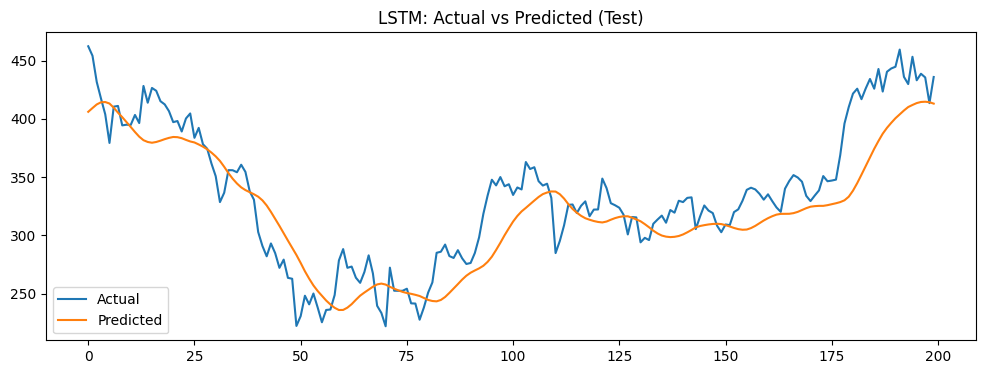

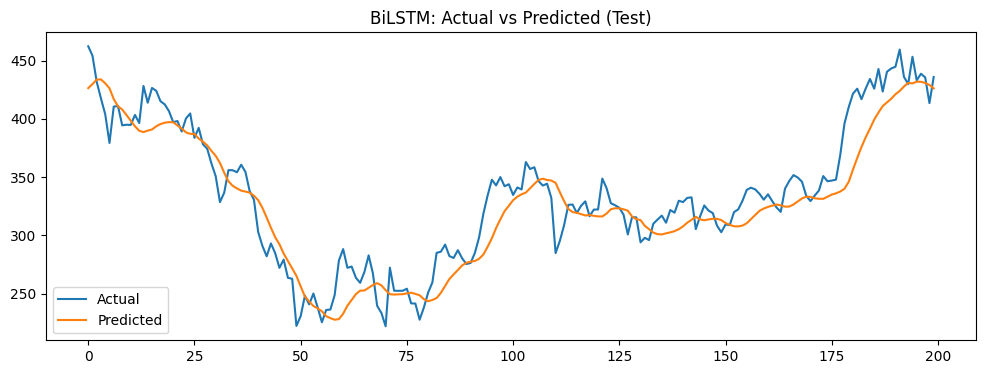

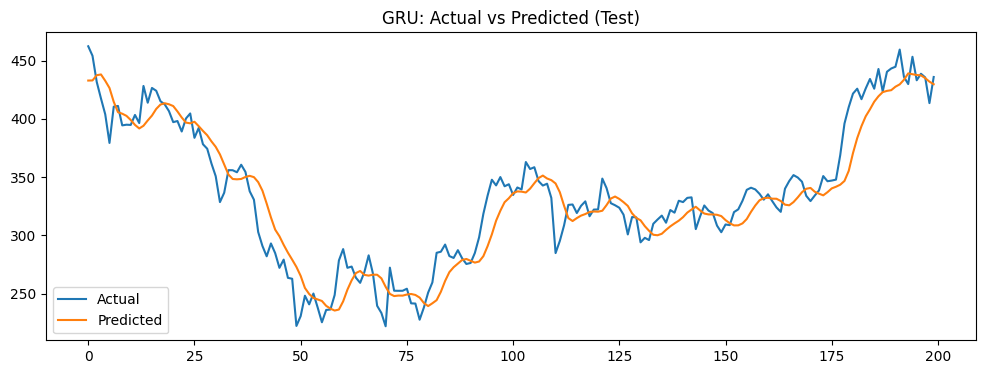

In [20]:
# Cell 17 — plot helper (last N points)
def plot_compare(y_true, preds, title, last_n=200):
    plt.figure(figsize=(12,4))
    plt.plot(y_true[-last_n:], label='Actual')
    plt.plot(preds[-last_n:], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

plot_compare(y_test_inv, lstm_pred, "LSTM: Actual vs Predicted (Test)", last_n=200)
plot_compare(y_test_inv, bilstm_pred, "BiLSTM: Actual vs Predicted (Test)", last_n=200)
plot_compare(y_test_inv, gru_pred, "GRU: Actual vs Predicted (Test)", last_n=200)


In [21]:
# Cell 18 — pick best by RMSE
rmse_dict = {'lstm': lstm_rmse, 'bilstm': bilstm_rmse, 'gru': gru_rmse}
best_name = min(rmse_dict, key=rmse_dict.get)
print("Best model by RMSE:", best_name, rmse_dict)
best_model = {'lstm': lstm, 'bilstm': bilstm, 'gru': gru}[best_name]

Best model by RMSE: gru {'lstm': 28.12659662079845, 'bilstm': 21.193438868865165, 'gru': 18.641017974981978}


In [22]:
# Cell 20 — save best model name explicitly
best_model.save(os.path.join(MODEL_DIR, f"tsla_best_model_{best_name}.h5"))
print("Saved best model:", os.path.join(MODEL_DIR, f"tesla_best_model_{best_name}.h5"))


Saved best model: saved_models/tesla_best_model_gru.h5
